In [33]:
%matplotlib inline

import numpy as np
import data_loader
import module
from data_loader import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import mxnet as mx
from mxnet import nd, autograd, gluon

ctx = mx.cpu()
data_ctx = ctx
model_ctx = ctx

## Custom Dataset class

In [34]:
dl = DataLoader()

class CustomDataset:
    
    def __init__(self, mode, dataset = 'all'):
        self.x, self.y = dl.load_data(mode, dataset)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.y)        

In [35]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        data = mx.ndarray.cast(data, dtype='float32')
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

# TRAINING

In [36]:
batch_size = 64

train_data = mx.gluon.data.DataLoader(CustomDataset('train', 'train'), batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(CustomDataset('train', 'validation'), batch_size, shuffle=False)

epochs = 15
num_examples = len(train_data)

## Deep Network

In [37]:
layer = [512, 128, 64, 32, 16]
lout = 10
net1 = gluon.nn.Sequential()
with net1.name_scope():
    net1.add(gluon.nn.Dense(layer[0], activation="relu"))
    net1.add(gluon.nn.Dense(layer[1], activation="relu"))
    net1.add(gluon.nn.Dense(layer[2], activation="relu"))
    net1.add(gluon.nn.Dense(layer[3], activation="relu"))
    net1.add(gluon.nn.Dense(layer[4], activation="relu"))
    net1.add(gluon.nn.Dense(lout))

In [38]:
net1.collect_params().initialize(mx.init.Uniform(.1), ctx=model_ctx, force_reinit=True)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net1.collect_params(), 'sgd', {'learning_rate': .001})

In [39]:
loss_arr = []
valid_acc = []
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        
        with autograd.record():
            data = mx.ndarray.cast(data, dtype='float32')
            output = net1(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    
    loss_arr.append(cumulative_loss/num_examples)

    test_accuracy = evaluate_accuracy(test_data, net1)
    train_accuracy = evaluate_accuracy(train_data, net1)
#     print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %(e, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    valid_acc.append(test_accuracy)

loss_arr1 = loss_arr.copy()
valid_acc1 = valid_acc.copy()

Epoch 0. Loss: 91.37245846665613, Train_acc 0.6524761904761904, Test_acc 0.6535555555555556
Epoch 1. Loss: 48.18423651995724, Train_acc 0.7479047619047619, Test_acc 0.745
Epoch 2. Loss: 40.15788326524709, Train_acc 0.7515238095238095, Test_acc 0.7479444444444444
Epoch 3. Loss: 36.19982702692168, Train_acc 0.7969761904761905, Test_acc 0.7905
Epoch 4. Loss: 33.88163188458215, Train_acc 0.7732380952380953, Test_acc 0.7678333333333334
Epoch 5. Loss: 32.19216015712674, Train_acc 0.8189047619047619, Test_acc 0.8117222222222222
Epoch 6. Loss: 30.807409186341445, Train_acc 0.7886904761904762, Test_acc 0.7816666666666666
Epoch 7. Loss: 29.736098368236828, Train_acc 0.828952380952381, Test_acc 0.8212222222222222
Epoch 8. Loss: 28.83474607119277, Train_acc 0.8149761904761905, Test_acc 0.8083333333333333
Epoch 9. Loss: 27.89152082097766, Train_acc 0.8171666666666667, Test_acc 0.8058888888888889
Epoch 10. Loss: 27.19635074468871, Train_acc 0.8529761904761904, Test_acc 0.8386666666666667
Epoch 11. L

In [40]:
filename = os.path.join('weights','a1.params')
net1.save_parameters(filename)

## Shallow Network

In [41]:
layer = [1024, 512, 256]
lout = 10
net2 = gluon.nn.Sequential()
with net2.name_scope():
    net2.add(gluon.nn.Dense(layer[0], activation="relu"))
    net2.add(gluon.nn.Dense(layer[1], activation="relu"))
    net2.add(gluon.nn.Dense(layer[2], activation="relu"))
    net2.add(gluon.nn.Dense(lout))

In [42]:
net2.collect_params().initialize(mx.init.Uniform(.1), ctx=model_ctx, force_reinit=True)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net2.collect_params(), 'sgd', {'learning_rate': .001})

In [43]:
loss_arr = []
valid_acc = []
for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        
        with autograd.record():
            data = mx.ndarray.cast(data, dtype='float32')
            output = net2(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()
    
    loss_arr.append(cumulative_loss/num_examples)

    test_accuracy = evaluate_accuracy(test_data, net2)
    train_accuracy = evaluate_accuracy(train_data, net2)
#     print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" %(e, cumulative_loss/num_examples, train_accuracy, test_accuracy)) 
    valid_acc.append(test_accuracy)

loss_arr2 = loss_arr.copy()
valid_acc2 = valid_acc.copy()

Epoch 0. Loss: 284.2032279648919, Train_acc 0.7595952380952381, Test_acc 0.7446666666666667
Epoch 1. Loss: 33.09280397104528, Train_acc 0.8371190476190477, Test_acc 0.8136111111111111
Epoch 2. Loss: 28.65866597058022, Train_acc 0.8395, Test_acc 0.813
Epoch 3. Loss: 25.91834103280914, Train_acc 0.8249047619047619, Test_acc 0.8005555555555556
Epoch 4. Loss: 24.06332854919782, Train_acc 0.8723333333333333, Test_acc 0.8374444444444444
Epoch 5. Loss: 22.54178304505312, Train_acc 0.8730952380952381, Test_acc 0.8375
Epoch 6. Loss: 21.37960065136943, Train_acc 0.8826666666666667, Test_acc 0.8423333333333334
Epoch 7. Loss: 20.317510324707495, Train_acc 0.8816904761904761, Test_acc 0.8427777777777777
Epoch 8. Loss: 19.43954952485304, Train_acc 0.8828095238095238, Test_acc 0.8377777777777777
Epoch 9. Loss: 18.586051157438956, Train_acc 0.8855, Test_acc 0.8397777777777777
Epoch 10. Loss: 17.90212858757472, Train_acc 0.8984761904761904, Test_acc 0.8491111111111111
Epoch 11. Loss: 17.262153825077654

In [44]:
filename = os.path.join('weights','a2.params')
net2.save_parameters(filename)

## Graphical Comparison

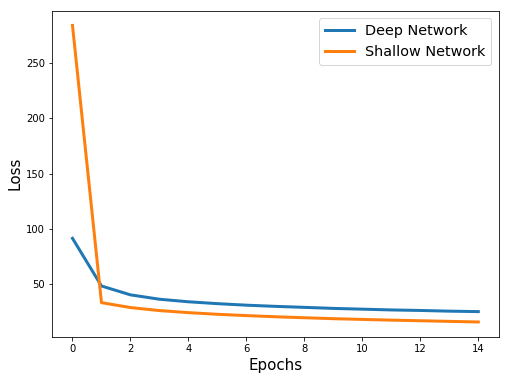

In [45]:
plt.figure(figsize=(8,6))
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.plot(loss_arr1, label='Deep Network', linewidth=3)
plt.plot(loss_arr2, label = 'Shallow Network', linewidth=3)
plt.legend(fontsize='x-large')
plt.show()

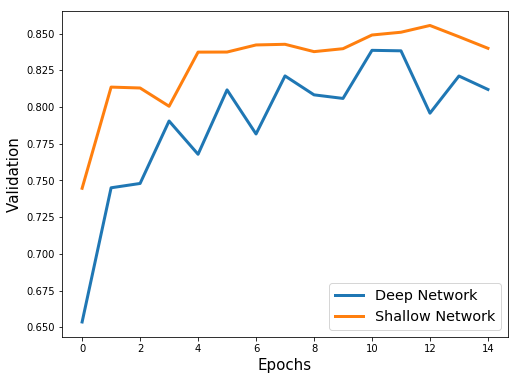

In [46]:
plt.figure(figsize=(8,6))
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Validation', fontsize=15)
plt.plot(valid_acc1, label='Deep Network', linewidth=3)
plt.plot(valid_acc2, label = 'Shallow Network', linewidth=3)
plt.legend(fontsize='x-large')
plt.show()

# TESTING

In [47]:
layer = [512, 128, 64, 32, 16]
lout = 10
net1 = gluon.nn.Sequential()
with net1.name_scope():
    net1.add(gluon.nn.Dense(layer[0], activation="relu"))
    net1.add(gluon.nn.Dense(layer[1], activation="relu"))
    net1.add(gluon.nn.Dense(layer[2], activation="relu"))
    net1.add(gluon.nn.Dense(layer[3], activation="relu"))
    net1.add(gluon.nn.Dense(layer[4], activation="relu"))
    net1.add(gluon.nn.Dense(lout))
filename = os.path.join('weights','a1.params')
if not (os.path.isfile(filename)):
    print('No data for NN1')
    sys.exit()
net1.load_parameters(filename, ctx=ctx)

layer = [1024, 512, 256]
lout = 10
net2 = gluon.nn.Sequential()
with net2.name_scope():
    net2.add(gluon.nn.Dense(layer[0], activation="relu"))
    net2.add(gluon.nn.Dense(layer[1], activation="relu"))
    net2.add(gluon.nn.Dense(layer[2], activation="relu"))
    net2.add(gluon.nn.Dense(lout))
filename = os.path.join('weights','a2.params')
if not (os.path.isfile(filename)):
    print('No data for NN2')
    sys.exit()
net2.load_parameters(filename, ctx=ctx)


In [48]:
test_data = mx.gluon.data.DataLoader(CustomDataset('test', 'validation'), batch_size, last_batch='keep', shuffle=False)
print(evaluate_accuracy(test_data, net1))
print(evaluate_accuracy(test_data, net2))


0.8093
0.8337
